## **Imports and basic loading**

In [1]:
import pandas as pd
import keras
import numpy as np
import os
from tqdm import tqdm
from time import time
from sklearn.metrics import roc_curve,roc_auc_score,f1_score,accuracy_score,precision_recall_curve
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,KFold
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image,ImageOps
import glob 
import cv2
import pickle
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 1.x
except Exception:
  pass

TensorFlow is already loaded. Please restart the runtime to change versions.


In [2]:
import tensorflow as tf

In [3]:
os.chdir("/content/drive/Shared drives/ECS 289G Deep Learning Project/Project/Datasets/")
!pwd

/content/drive/Shared drives/ECS 289G Deep Learning Project/Project/Datasets


In [4]:
!ls

 bin_files			 Filter_Dataset_script.ipynb
'csv files'			 images
 Data_Entry_2017_v2020.gsheet	 images_zip_files
 Dataset_Process_Details.ipynb


## **Working with csv and adding full path for the images**

In [ ]:
df = pd.read_csv("csv files/no_sampling_index_csv/df_PA.csv")
df = df.iloc[:,:-1]

In [ ]:
df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143000,0.143000
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143000,0.143000
2,00000001_002.png,Effusion,2,1,58,M,PA,2500,2048,0.168000,0.168000
3,00000001_002.png,Cardiomegaly,2,1,58,M,PA,2500,2048,0.168000,0.168000
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143000,0.143000
...,...,...,...,...,...,...,...,...,...,...,...
18991,00030773_001.png,No Finding,1,30773,10,M,PA,2021,2021,0.194311,0.194311
18992,00030792_000.png,No Finding,0,30792,10,F,PA,1775,1712,0.194311,0.194311
18993,00030792_001.png,No Finding,1,30792,10,F,PA,1663,1675,0.194311,0.194311
18994,00030801_000.png,No Finding,0,30801,39,M,PA,2500,2048,0.168000,0.168000


In [ ]:
df_final = pd.DataFrame(columns=df.columns)
for _,record in df.iloc[:,:].iterrows():
  rec = record.copy(deep=True)
  if '|' in str(record['Finding Labels']):
    labels = str(record['Finding Labels']).split('|')
    for label in labels:
      rec['Finding Labels'] = label
      df_final= df_final.append(rec,ignore_index=True)
  else:
    df_final = df_final.append(record,ignore_index=True)

df_final

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143000,0.143000
1,00000001_001.png,Cardiomegaly,1,1,58,M,PA,2894,2729,0.143000,0.143000
2,00000001_001.png,Emphysema,1,1,58,M,PA,2894,2729,0.143000,0.143000
3,00000001_002.png,Effusion,2,1,58,M,PA,2500,2048,0.168000,0.168000
4,00000001_002.png,Cardiomegaly,2,1,58,M,PA,2500,2048,0.168000,0.168000
...,...,...,...,...,...,...,...,...,...,...,...
20254,00030792_000.png,No Finding,0,30792,10,F,PA,1775,1712,0.194311,0.194311
20255,00030792_001.png,No Finding,1,30792,10,F,PA,1663,1675,0.194311,0.194311
20256,00030801_000.png,No Finding,0,30801,39,M,PA,2500,2048,0.168000,0.168000
20257,00030801_001.png,Mass,1,30801,39,M,PA,2048,2500,0.168000,0.168000


In [ ]:
my_glob = glob.glob('images/images*/*.png')
print('Number of Observations: ', len(my_glob)) # Number of photos should equal 112,120

Number of Observations:  112121


In [ ]:
my_glob[:100]

['images/images1/00001230_007.png',
 'images/images1/00001230_008.png',
 'images/images1/00001231_000.png',
 'images/images1/00001231_001.png',
 'images/images1/00001231_002.png',
 'images/images1/00001232_000.png',
 'images/images1/00001232_001.png',
 'images/images1/00001232_002.png',
 'images/images1/00001232_003.png',
 'images/images1/00001232_004.png',
 'images/images1/00001232_005.png',
 'images/images1/00001232_006.png',
 'images/images1/00001233_000.png',
 'images/images1/00001234_000.png',
 'images/images1/00001235_000.png',
 'images/images1/00001235_001.png',
 'images/images1/00001236_000.png',
 'images/images1/00001237_000.png',
 'images/images1/00001237_001.png',
 'images/images1/00001238_000.png',
 'images/images1/00001238_001.png',
 'images/images1/00001238_002.png',
 'images/images1/00001238_003.png',
 'images/images1/00001239_000.png',
 'images/images1/00001240_000.png',
 'images/images1/00001241_000.png',
 'images/images1/00001242_000.png',
 'images/images1/00001243_00

In [ ]:
full_img_paths = {os.path.basename(x): x for x in my_glob}
df_final['full_path'] = df_final['Image Index'].map(full_img_paths.get)

In [ ]:
df_final

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],full_path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143000,0.143000,images/images1/00000001_000.png
1,00000001_001.png,Cardiomegaly,1,1,58,M,PA,2894,2729,0.143000,0.143000,images/images1/00000001_001.png
2,00000001_001.png,Emphysema,1,1,58,M,PA,2894,2729,0.143000,0.143000,images/images1/00000001_001.png
3,00000001_002.png,Effusion,2,1,58,M,PA,2500,2048,0.168000,0.168000,images/images1/00000001_002.png
4,00000001_002.png,Cardiomegaly,2,1,58,M,PA,2500,2048,0.168000,0.168000,images/images1/00000001_002.png
...,...,...,...,...,...,...,...,...,...,...,...,...
20254,00030792_000.png,No Finding,0,30792,10,F,PA,1775,1712,0.194311,0.194311,images/images12/00030792_000.png
20255,00030792_001.png,No Finding,1,30792,10,F,PA,1663,1675,0.194311,0.194311,images/images12/00030792_001.png
20256,00030801_000.png,No Finding,0,30801,39,M,PA,2500,2048,0.168000,0.168000,images/images12/00030801_000.png
20257,00030801_001.png,Mass,1,30801,39,M,PA,2048,2500,0.168000,0.168000,images/images12/00030801_001.png


In [ ]:
df_final.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'full_path'],
      dtype='object')

In [ ]:
df_final.to_csv("csv files/no_sampling_index_csv/added_paths_PA.csv",index=False)

## **Frequency distribution for the output labels**

                    Finding Labels
No Finding                   11561
Infiltration                  2278
Effusion                      1178
Atelectasis                   1033
Nodule                         934
Mass                           618
Pleural_Thickening             557
Fibrosis                       550
Pneumothorax                   500
Cardiomegaly                   328
Consolidation                  294
Emphysema                      169
Pneumonia                      152
Hernia                          79
Edema                           28


(<matplotlib.axes._subplots.AxesSubplot at 0x7fb9946cdd30>,
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
  <a list of 15 Text major ticklabel objects>))

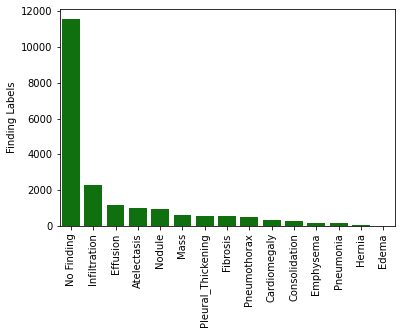

In [ ]:
#Frequency distribution for the labels
count_per_unique_label = df_final['Finding Labels'].value_counts()
df_count_per_unique_label = count_per_unique_label.to_frame() # convert series to dataframe for plotting purposes

print(df_count_per_unique_label) # view tabular results
sns.barplot(x = df_count_per_unique_label.index[:], y="Finding Labels", data=df_count_per_unique_label[:], color = "green"), plt.xticks(rotation = 90) # visualize results graphically

## **Train/Test/Validation dataset**

Referenced from 
1. https://www.kaggle.com/redwankarimsony/nih-chest-x-ray8-classifier-cnn-visualization
2. https://www.kaggle.com/adamjgoren/nih-chest-x-ray-multi-classification

In [ ]:
df = pd.read_csv("csv files/no_sampling_index_csv/added_paths_PA.csv")
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],full_path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,images/images1/00000001_000.png
1,00000001_001.png,Cardiomegaly,1,1,58,M,PA,2894,2729,0.143,0.143,images/images1/00000001_001.png
2,00000001_001.png,Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,images/images1/00000001_001.png
3,00000001_002.png,Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,images/images1/00000001_002.png
4,00000001_002.png,Cardiomegaly,2,1,58,M,PA,2500,2048,0.168,0.168,images/images1/00000001_002.png


In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (256,256)
TRAIN_SIZE = 2000
VAL_SIZE = 1000
TEST_SIZE = 400

In [ ]:
#1. Break into train-val-test datasets (DONE)
#2. Then, we need to work on getting the image repr of each image (DONE)
#3. seperate into x_train,x_test,y_train,y_test like our HW (DONE)
#4. Develop a simple CNN model for image prediction (DONE)
#5. Write a model function (DONE)
#6. Then have a 5 fold CV for the CNN and then have ROC, PR, Accuracy, F1 scores and confusion matrix

In [ ]:
with open("csv files/train_val_list.txt",'r') as f:
  train_links = [line.strip() for line in f.readlines()]
  train_links = np.array(train_links).astype(str)

print(f"Number of train_samples: {len(train_links)}")
train_links[:10]

Number of train_samples: 86524


array(['00000001_000.png', '00000001_001.png', '00000001_002.png',
       '00000002_000.png', '00000004_000.png', '00000005_000.png',
       '00000005_001.png', '00000005_002.png', '00000005_003.png',
       '00000005_004.png'], dtype='<U16')

In [ ]:
with open("csv files/test_list.txt",'r') as f:
  test_links = [line.strip() for line in f.readlines()]
  test_links = np.array(test_links).astype(str)
print(f"Number of test_samples: {len(test_links)}")
test_links[:10]

Number of test_samples: 25596


array(['00000003_000.png', '00000003_001.png', '00000003_002.png',
       '00000003_003.png', '00000003_004.png', '00000003_005.png',
       '00000003_006.png', '00000003_007.png', '00000013_000.png',
       '00000013_001.png'], dtype='<U16')

In [ ]:
df_train = df[df['Image Index'].isin(train_links)]
df_test = df[df['Image Index'].isin(test_links)]

In [ ]:
val_split = 0.1 #last 10% of the train data
num_train_overall = df_train.shape[0]
df_train_final = df_train.iloc[:-int(val_split * num_train_overall),:]
df_val = df_train.iloc[-int(val_split * num_train_overall):,:]

In [ ]:
classes = ['No Finding','Infiltration',
           'Effusion','Atelectasis','Nodule', 'Mass',
           'Pleural_Thickening','Fibrosis','Pneumothorax',
           'Cardiomegaly','Consolidation','Emphysema',
           'Pneumonia','Hernia','Edema']

mapper = dict(zip(classes, range(0,len(classes))))
mapper

{'Atelectasis': 3,
 'Cardiomegaly': 9,
 'Consolidation': 10,
 'Edema': 14,
 'Effusion': 2,
 'Emphysema': 11,
 'Fibrosis': 7,
 'Hernia': 13,
 'Infiltration': 1,
 'Mass': 5,
 'No Finding': 0,
 'Nodule': 4,
 'Pleural_Thickening': 6,
 'Pneumonia': 12,
 'Pneumothorax': 8}

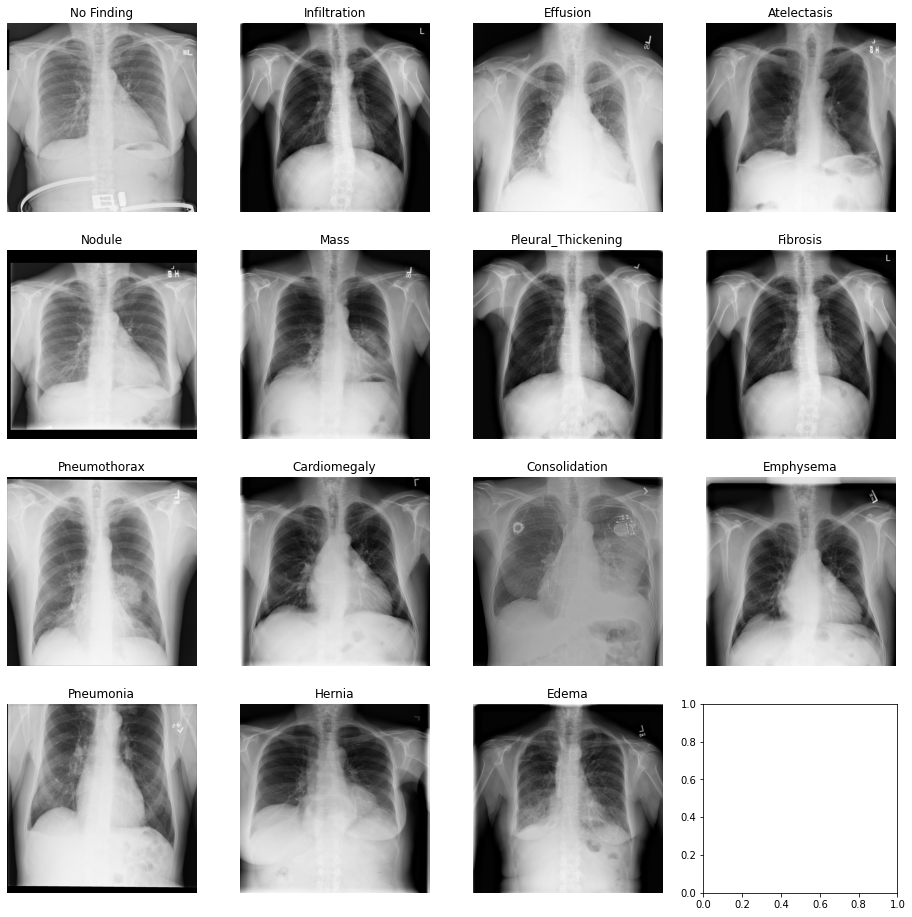

In [ ]:
#plot random samples for each class in a subplot basis
fig, axs = plt.subplots(nrows=4,ncols=4,figsize = (16, 16))
for cl in mapper.keys():
  i = mapper[cl] // 4
  j = mapper[cl] % 4
  sample = df_train_final[df_train_final['Finding Labels'] == cl].iloc[0,:]
  path = sample['full_path']
  image = mpimg.imread(path)
  axs[i,j].imshow(image,cmap="gray")
  axs[i,j].set_title(cl)
  axs[i,j].axis('off')

In [ ]:
for cl in classes:
  df_train_final[cl] = df_train_final['Finding Labels'].map(lambda result: 1.0 if cl in result else 0)
  df_val[cl] = df_val['Finding Labels'].map(lambda result: 1.0 if cl in result else 0)
  df_test[cl] = df_test['Finding Labels'].map(lambda result: 1.0 if cl in result else 0)


df_train_final['target_vector'] = df_train_final.apply(lambda target: [target[classes].values], 1).map(lambda target: target[0])
df_val['target_vector'] = df_val.apply(lambda target: [target[classes].values], 1).map(lambda target: target[0])
df_test['target_vector'] = df_test.apply(lambda target: [target[classes].values], 1).map(lambda target: target[0])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
#TRAIN WITH TRAIN SIZE SAMPLES
df_train_final = df_train_final.iloc[:TRAIN_SIZE,:]
df_val = df_val.iloc[:VAL_SIZE,:]

In [ ]:
df_test = df_test.iloc[-TEST_SIZE:,:]

In [ ]:
df_train_final

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],full_path,No Finding,Infiltration,Effusion,Atelectasis,Nodule,Mass,Pleural_Thickening,Fibrosis,Pneumothorax,Cardiomegaly,Consolidation,Emphysema,Pneumonia,Hernia,Edema,target_vector
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143000,0.143000,images/images1/00000001_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,00000001_001.png,Cardiomegaly,1,1,58,M,PA,2894,2729,0.143000,0.143000,images/images1/00000001_001.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,00000001_001.png,Emphysema,1,1,58,M,PA,2894,2729,0.143000,0.143000,images/images1/00000001_001.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,00000001_002.png,Effusion,2,1,58,M,PA,2500,2048,0.168000,0.168000,images/images1/00000001_002.png,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,00000001_002.png,Cardiomegaly,2,1,58,M,PA,2500,2048,0.168000,0.168000,images/images1/00000001_002.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2149,00001821_000.png,No Finding,0,1821,56,M,PA,2512,2568,0.143000,0.143000,images/images2/00001821_000.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2150,00001821_001.png,No Finding,1,1821,54,M,PA,2992,2991,0.143000,0.143000,images/images2/00001821_001.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2151,00001824_000.png,No Finding,0,1824,76,M,PA,2021,2021,0.194311,0.194311,images/images2/00001824_000.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2152,00001824_001.png,No Finding,1,1824,76,M,PA,2021,2021,0.194311,0.194311,images/images2/00001824_001.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
df_val

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],full_path,No Finding,Infiltration,Effusion,Atelectasis,Nodule,Mass,Pleural_Thickening,Fibrosis,Pneumothorax,Cardiomegaly,Consolidation,Emphysema,Pneumonia,Hernia,Edema,target_vector
17982,00025071_001.png,Effusion,1,25071,55,M,PA,2992,2991,0.143,0.143,images/images11/00025071_001.png,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
17983,00025071_001.png,Nodule,1,25071,55,M,PA,2992,2991,0.143,0.143,images/images11/00025071_001.png,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
17984,00025071_002.png,Pleural_Thickening,2,25071,55,M,PA,2820,2693,0.143,0.143,images/images11/00025071_002.png,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
17985,00025071_002.png,Mass,2,25071,55,M,PA,2820,2693,0.143,0.143,images/images11/00025071_002.png,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
17986,00025075_000.png,No Finding,0,25075,8,F,PA,1948,1716,0.143,0.143,images/images11/00025075_000.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19032,00027043_000.png,No Finding,0,27043,18,M,PA,2992,2991,0.143,0.143,images/images11/00027043_000.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
19033,00027043_001.png,Infiltration,1,27043,19,M,PA,2992,2991,0.143,0.143,images/images11/00027043_001.png,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
19034,00027043_002.png,Infiltration,2,27043,19,M,PA,2990,2991,0.143,0.143,images/images11/00027043_002.png,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
19035,00027047_000.png,No Finding,0,27047,61,M,PA,2992,2991,0.143,0.143,images/images11/00027047_000.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
df_test

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],full_path,No Finding,Infiltration,Effusion,Atelectasis,Nodule,Mass,Pleural_Thickening,Fibrosis,Pneumothorax,Cardiomegaly,Consolidation,Emphysema,Pneumonia,Hernia,Edema,target_vector
17770,00023696_002.png,No Finding,2,23696,57,M,PA,2021,2021,0.194311,0.194311,images/images10/00023696_002.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
17771,00023696_003.png,No Finding,3,23696,48,M,PA,2992,2713,0.143000,0.143000,images/images10/00023696_003.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
17772,00023696_004.png,Atelectasis,4,23696,49,M,PA,2582,2991,0.143000,0.143000,images/images10/00023696_004.png,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
17773,00023696_005.png,No Finding,5,23696,51,M,PA,2992,2533,0.143000,0.143000,images/images10/00023696_005.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
17774,00023696_006.png,Fibrosis,6,23696,52,M,PA,2826,2797,0.143000,0.143000,images/images10/00023696_006.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20247,00030680_001.png,No Finding,1,30680,36,F,PA,2021,2011,0.194311,0.194311,images/images12/00030680_001.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
20252,00030773_000.png,No Finding,0,30773,10,M,PA,2021,2021,0.194311,0.194311,images/images12/00030773_000.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
20253,00030773_001.png,No Finding,1,30773,10,M,PA,2021,2021,0.194311,0.194311,images/images12/00030773_001.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
20254,00030792_000.png,No Finding,0,30792,10,F,PA,1775,1712,0.194311,0.194311,images/images12/00030792_000.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## **Create the features and the label variables**

In [ ]:
def get_vect(df,vect_col):
  y = np.empty((1,15))
  for vec in df[vect_col].values:
    y = np.vstack((y,vec))
  
  y = y[1:]
  print(y.shape)
  return y

In [ ]:
def get_image_data(df,path_col,image_size = IMAGE_SIZE):
  num_samples = df.shape[0]
  X = []
  i = 0
  image_paths = df[path_col].values

  for path in tqdm(image_paths):
    image = Image.open(path)
    image = image.convert('L')
    image = np.asarray(image.resize(image_size))
    X.append(image)
  
  print("Shape of the X vector: ",len(X),image_size)
  return X

In [ ]:
print("Getting TRAIN DATA")
y_train = get_vect(df_train_final,'target_vector')
%time X_train = get_image_data(df_train_final,"full_path")
print("Getting VAL DATA")
y_val = get_vect(df_val,'target_vector')
%time X_val = get_image_data(df_val,"full_path")

  0%|          | 0/2000 [00:00<?, ?it/s]

Getting TRAIN DATA
(2000, 15)


  0%|          | 5/1000 [00:00<00:24, 40.99it/s]

Shape of the X vector:  2000 (256, 256)
CPU times: user 48.6 s, sys: 1.74 s, total: 50.3 s
Wall time: 58 s
Getting VAL DATA
(1000, 15)


100%|██████████| 1000/1000 [00:24<00:00, 41.48it/s]

Shape of the X vector:  1000 (256, 256)
CPU times: user 20.7 s, sys: 770 ms, total: 21.5 s
Wall time: 24.1 s


In [ ]:
X_train[:10]

[array([[194, 189, 181, ...,   5,   5,   3],
        [187, 179, 151, ...,   5,   5,   3],
        [176, 149,  93, ...,   5,   5,   3],
        ...,
        [254, 238, 200, ...,   0,   0,   0],
        [254, 238, 200, ...,   2,   0,   0],
        [255, 240, 199, ...,   7,   0,   0]], dtype=uint8),
 array([[205, 204, 202, ..., 196, 199, 192],
        [204, 202, 199, ..., 193, 196, 187],
        [203, 200, 197, ..., 189, 192, 183],
        ...,
        [ 77,  36,  16, ...,   8,   1,   0],
        [ 77,  37,  16, ...,   7,   1,   0],
        [ 78,  36,  16, ...,   6,   1,   0]], dtype=uint8),
 array([[205, 204, 202, ..., 196, 199, 192],
        [204, 202, 199, ..., 193, 196, 187],
        [203, 200, 197, ..., 189, 192, 183],
        ...,
        [ 77,  36,  16, ...,   8,   1,   0],
        [ 77,  37,  16, ...,   7,   1,   0],
        [ 78,  36,  16, ...,   6,   1,   0]], dtype=uint8),
 array([[ 15,  13,  11, ...,  24,  24,  24],
        [ 16,  14,  12, ...,  23,  24,  23],
        [ 15,  1

In [ ]:
X_train = np.array(X_train)
X_train.shape

(2000, 256, 256)

In [ ]:
X_val = np.array(X_val)
X_val.shape

(1000, 256, 256)

In [ ]:
y_test = get_vect(df_test,"target_vector")
%time X_test = get_image_data(df_test,"full_path")
X_test = np.array(X_test)
X_test.shape

  1%|          | 4/400 [00:00<00:10, 37.83it/s]

(400, 15)


100%|██████████| 400/400 [00:10<00:00, 39.97it/s]

Shape of the X vector:  400 (256, 256)
CPU times: user 8.64 s, sys: 331 ms, total: 8.97 s
Wall time: 10 s


(400, 256, 256)

In [ ]:
X_train_scale = X_train / 255.00
X_train_scale = np.asarray(X_train_scale).astype(np.float32)
X_train_scale

array([[[0.7607843 , 0.7411765 , 0.70980394, ..., 0.01960784,
         0.01960784, 0.01176471],
        [0.73333335, 0.7019608 , 0.5921569 , ..., 0.01960784,
         0.01960784, 0.01176471],
        [0.6901961 , 0.58431375, 0.3647059 , ..., 0.01960784,
         0.01960784, 0.01176471],
        ...,
        [0.99607843, 0.93333334, 0.78431374, ..., 0.        ,
         0.        , 0.        ],
        [0.99607843, 0.93333334, 0.78431374, ..., 0.00784314,
         0.        , 0.        ],
        [1.        , 0.9411765 , 0.78039217, ..., 0.02745098,
         0.        , 0.        ]],

       [[0.8039216 , 0.8       , 0.7921569 , ..., 0.76862746,
         0.78039217, 0.7529412 ],
        [0.8       , 0.7921569 , 0.78039217, ..., 0.75686276,
         0.76862746, 0.73333335],
        [0.79607844, 0.78431374, 0.77254903, ..., 0.7411765 ,
         0.7529412 , 0.7176471 ],
        ...,
        [0.3019608 , 0.14117648, 0.0627451 , ..., 0.03137255,
         0.00392157, 0.        ],
        [0.3

In [ ]:
X_val_scale = X_val/255.00
X_val_scale = np.asarray(X_val_scale).astype(np.float32)
X_val_scale

array([[[0.        , 0.        , 0.        , ..., 0.6431373 ,
         0.7294118 , 0.7176471 ],
        [0.        , 0.        , 0.        , ..., 0.3254902 ,
         0.5568628 , 0.6627451 ],
        [0.        , 0.        , 0.        , ..., 0.06666667,
         0.25882354, 0.49411765],
        ...,
        [0.        , 0.        , 0.        , ..., 0.03921569,
         0.26666668, 0.47058824],
        [0.        , 0.        , 0.        , ..., 0.03529412,
         0.2784314 , 0.4862745 ],
        [0.        , 0.        , 0.        , ..., 0.03137255,
         0.2784314 , 0.5019608 ]],

       [[0.        , 0.        , 0.        , ..., 0.6431373 ,
         0.7294118 , 0.7176471 ],
        [0.        , 0.        , 0.        , ..., 0.3254902 ,
         0.5568628 , 0.6627451 ],
        [0.        , 0.        , 0.        , ..., 0.06666667,
         0.25882354, 0.49411765],
        ...,
        [0.        , 0.        , 0.        , ..., 0.03921569,
         0.26666668, 0.47058824],
        [0. 

In [ ]:
X_test_scale = X_test/255.00
X_test_scale = np.asarray(X_test_scale).astype(np.float32)
X_test_scale

array([[[0.21176471, 0.14117648, 0.09411765, ..., 0.27058825,
         0.2784314 , 0.2901961 ],
        [0.20784314, 0.13725491, 0.09019608, ..., 0.14117648,
         0.14509805, 0.15686275],
        [0.20392157, 0.13725491, 0.08627451, ..., 0.07058824,
         0.07450981, 0.08235294],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.01568628, 0.06666667],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.01960784, 0.06666667],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.01960784, 0.06666667]],

       [[0.74509805, 0.72156864, 0.68235296, ..., 0.11372549,
         0.11764706, 0.10980392],
        [0.7019608 , 0.6627451 , 0.52156866, ..., 0.00784314,
         0.00784314, 0.00784314],
        [0.6392157 , 0.49019608, 0.26666668, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.11372549, 0.02745098, 0.00392157, ..., 0.00392157,
         0.00392157, 0.00392157],
        [0.1

In [ ]:
y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)

In [ ]:
y_test = y_test.astype(np.float32)

In [ ]:
X_train_scale = X_train_scale.reshape((X_train_scale.shape[0], X_train_scale.shape[1], X_train_scale.shape[2], 1 ))
X_val_scale = X_val_scale.reshape((X_val_scale.shape[0], X_val_scale.shape[1], X_val_scale.shape[2], 1 ))

In [ ]:
X_test_scale = X_test_scale.reshape((X_test_scale.shape[0],X_test_scale.shape[1],X_test_scale.shape[2],1 ))

##**Save the variables**

In [ ]:
!pwd

/content/drive/Shareddrives/ECS 289G Deep Learning Project/Project/Datasets


In [ ]:
!ls

'csv files'			 Filter_Dataset_script.ipynb
 Data_Entry_2017_v2020.gsheet	 images
 Dataset_Process_Details.ipynb	 images_zip_files


In [ ]:
!mkdir bin_files/

In [ ]:
!ls

 bin_files			 Filter_Dataset_script.ipynb
'csv files'			 images
 Data_Entry_2017_v2020.gsheet	 images_zip_files
 Dataset_Process_Details.ipynb


In [ ]:
with open("bin_files/train.pkl",'wb') as f:
  pickle.dump((X_train_scale,y_train),f)

with open("bin_files/val.pkl",'wb') as f:
  pickle.dump((X_val_scale,y_val),f)

In [ ]:
with open("bin_files/test.pkl",'wb') as f:
  pickle.dump((X_test_scale,y_test),f)